In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)
    
    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)
    
    def __len__(self):
        return len(self.memory)

In [11]:
class FrozenLakeDQL():
    learning_rate_a = 0.001
    discount_factor_g = 0.9
    network_sync_rate = 10
    replay_memory_size = 1000
    mini_batch_size = 32
    
    loss_fn = nn.MSELoss()
    optimizer = None
    
    ACTIONS = ['L', 'D', 'R', 'U']
    
    def train(self, episodes, render = False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        
        epsilon = 1
        memory = ReplayMemory(self.replay_memory_size)
        
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        
        target_dqn.load_state_dict(policy_dqn.state_dict())
        
        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)
        
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)
        
        rewards_per_episode = np.zeros(episodes)
        
        epsilon_history = []
        
        step_count = 0
        
        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False
            
            while(not terminated and not truncated):
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                        
                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated))

                state = new_state
                step_count += 1
            
            if reward == 1:
                rewards_per_episode[i] = 1
            
            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)
                
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)
                
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0
                    
        env.close()
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")
        plt.figure(1)
        
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121)
        plt.plot(sum_rewards)
        
        plt.subplot(122)
        plt.plot(epsilon_history)
        
        plt.savefig('frozen_lake_dql.png')
        
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        num_states = policy_dqn.fc1.in_features
        
        current_q_list = []
        target_q_list = []
        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )                
            
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)
            
            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            target_q[action] = target
            target_q_list.append(target_q)
            
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def state_to_dqn_input(self, state:int, num_states:int) -> torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor
    
    def test(self, episodes, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name = '4x4', is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()             
        
        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()[0]  
            terminated = False      
            truncated = False                   

            while(not terminated and not truncated):  
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                state,reward,terminated,truncated,_ = env.step(action)

        env.close()
        
    def print_dqn(self, dqn):
        num_states = dqn.fc1.in_features

        for s in range(num_states):
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  
            q_values=q_values.rstrip()              

            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            print(f'{s:02},{best_action},[{q_values}]', end=' ')         
            if (s+1)%4==0:
                print()
        

Policy (random, before training):
00,D,[+0.06 +0.16 -0.03 -0.14] 01,D,[+0.17 +0.23 +0.02 -0.18] 02,D,[+0.17 +0.24 -0.05 -0.20] 03,D,[+0.10 +0.16 +0.06 -0.16] 
04,D,[+0.14 +0.30 -0.03 -0.28] 05,L,[+0.18 +0.09 +0.01 -0.12] 06,D,[+0.08 +0.10 +0.05 -0.09] 07,D,[+0.17 +0.20 -0.01 -0.19] 
08,D,[+0.08 +0.18 -0.00 -0.13] 09,D,[+0.12 +0.20 +0.05 -0.18] 10,D,[+0.09 +0.32 -0.04 -0.21] 11,D,[+0.15 +0.18 +0.02 -0.15] 
12,L,[+0.21 +0.15 -0.02 -0.19] 13,D,[+0.09 +0.24 -0.10 -0.17] 14,D,[+0.13 +0.23 -0.03 -0.13] 15,D,[+0.10 +0.14 +0.11 -0.14] 


c:\Users\anshu\miniconda3\envs\ml-zoomcamp\Lib\site-packages\gymnasium\utils\passive_env_checker.py:249: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\anshu\AppData\Local\Temp\ipykernel_28160\2228758045.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you

Policy (trained):
00,R,[+0.53 +0.58 +0.58 +0.54] 01,R,[+0.57 +0.15 +0.65 +0.53] 02,D,[+0.58 +0.73 +0.52 +0.64] 03,L,[+0.59 +0.31 +0.43 +0.53] 
04,D,[+0.60 +0.65 +0.01 +0.53] 05,L,[+0.56 +0.21 +0.38 +0.52] 06,D,[+0.26 +0.82 -0.01 +0.66] 07,L,[+0.56 +0.53 +0.43 +0.39] 
08,R,[+0.63 +0.02 +0.73 +0.59] 09,R,[+0.65 +0.80 +0.83 +0.19] 10,D,[+0.71 +0.92 +0.01 +0.71] 11,L,[+0.59 +0.51 +0.44 +0.42] 
12,L,[+0.62 +0.36 +0.32 +0.41] 13,R,[+0.51 +0.77 +0.92 +0.62] 14,R,[+0.81 +0.90 +1.01 +0.78] 15,R,[+0.45 +0.38 +0.72 +0.40] 


c:\Users\anshu\miniconda3\envs\ml-zoomcamp\Lib\site-packages\gymnasium\utils\passive_env_checker.py:249: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


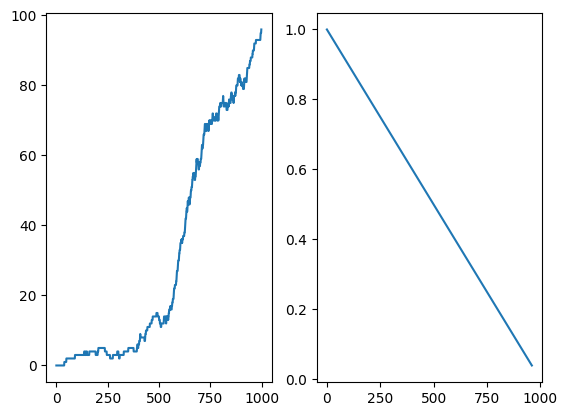

In [12]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery = False
    frozen_lake.train(1000, is_slippery=is_slippery)
    frozen_lake.test(10, is_slippery=is_slippery)

In [13]:
frozen_lake.test(10, is_slippery=is_slippery)

C:\Users\anshu\AppData\Local\Temp\ipykernel_28160\2228758045.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"

Policy (trained):
00,R,[+0.53 +0.58 +0.58 +0.54] 01,R,[+0.57 +0.15 +0.65 +0.53] 02,D,[+0.58 +0.73 +0.52 +0.64] 03,L,[+0.59 +0.31 +0.43 +0.53] 
04,D,[+0.60 +0.65 +0.01 +0.53] 05,L,[+0.56 +0.21 +0.38 +0.52] 06,D,[+0.26 +0.82 -0.01 +0.66] 07,L,[+0.56 +0.53 +0.43 +0.39] 
08,R,[+0.63 +0.02 +0.73 +0.59] 09,R,[+0.65 +0.80 +0.83 +0.19] 10,D,[+0.71 +0.92 +0.01 +0.71] 11,L,[+0.59 +0.51 +0.44 +0.42] 
12,L,[+0.62 +0.36 +0.32 +0.41] 13,R,[+0.51 +0.77 +0.92 +0.62] 14,R,[+0.81 +0.90 +1.01 +0.78] 15,R,[+0.45 +0.38 +0.72 +0.40] 
